# Vignette 4: Recovery of dysregulated kinases in response to cancer mutations

In this vignette, we will explore another way to evaluate networks, this time using a more biological approach. We will use the Clinical Proteomic Tumor Analysis Consortium (CPTAC) data, a compendium of tissue samples from 10 different cancer types, along with their respective adjacent, healthy tissue, samples.

> Ellis, M. J. et al. Connecting genomic alterations to cancer biology with proteomics: the NCI Clinical Proteomic Tumor Analysis Consortium. *Cancer Discov. 3, 1108–1112 (2013)*.

> Li, Y. et al. Proteogenomic data and resources for pan-cancer analysis. *Cancer Cell 41, 1397–1406 (2023)*.


In this setting, we will use a multiomics approach as follows:
* First, we will identify the most differentially abundant receptors in the proteomics profiles between healthy and tumor samples. We assume that if they are differentially abundant, they will be activated/inhibited.
* Second, we will use the transcriptomics data to perform TF enrichment analysis, in order to get the TFs that are dysregulated in the tumor samples compared to the healthy control.
* Lastly, we will use phosphoproteomics to perform kinase activity estimation and then evaluate the level of dysregulation in the resulting subnetwork. Hopefully, we will be able to assess whether these subnetworks contain a higher share of dysregulated elements compared to the overall phosphoproteome, and against random models.

## 1. Data processing

In [14]:
import networkcommons as nc
import pandas as pd
import numpy as np
import decoupler as dc

NetworkCommons provide a series of util functions to retrieve the CPTAC tables in an easy way. We can use the [`cptac_cohorsize`](../api/networkcommons.data.omics.cptac_cohortsize.html) function to visualise the different cancer samples, the [`cptac_fileinfo`](../api/networkcommons.data.omics.cptac_fileinfo.html) function to visualise the different files, and the [``cptac_datatypes``](../api/networkcommons.data.omics.cptac_datatypes.html). Finally, we will get the tables using the [`cptac_table()`](../api/networkcommons.data.omics.cptac_table.html) function. We will skip to this last function, but feel free to try them all :)

In [15]:
cptac_transcriptomics_tumor = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_proteomics_tumor = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_phosphoproteomics_tumor = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Tumor').set_index('idx').add_suffix('_tumor').reset_index()
cptac_transcriptomics_ctrl = nc.data.omics.cptac_table('rna', 'LSCC', 'RNAseq_gene_RSEM_coding_UQ_1500_log2_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_proteomics_ctrl = nc.data.omics.cptac_table('proteome', 'LSCC', 'proteomics_gene_abundance_log2_reference_intensity_normalized_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_phosphoproteomics_ctrl = nc.data.omics.cptac_table('phosphoproteome', 'LSCC', 'phospho_site_abundance_log2_reference_intensity_normalized_Normal').set_index('idx').add_suffix('_ctrl').reset_index()
cptac_meta = nc.data.omics.cptac_table('metadata', 'LSCC', 'meta')
cptac_meta.drop(0, axis=0, inplace=True)

In [16]:
cptac_meta = nc.data.omics.cptac_extend_dataframe(cptac_meta)

In [17]:
transcriptomics = pd.merge(cptac_transcriptomics_ctrl, cptac_transcriptomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
proteomics = pd.merge(cptac_proteomics_ctrl, cptac_proteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))
phosphoproteomics = pd.merge(cptac_phosphoproteomics_ctrl, cptac_phosphoproteomics_tumor, left_on='idx', right_on='idx', how='outer', suffixes=('_ctrl', '_tumor'))

Now, since we have duplicated the samples by adding either _ctrl or _tumor suffixes, we need to update the according metadata

In [18]:
transcriptomics_meta = pd.DataFrame({'sample_ID': transcriptomics.set_index('idx').columns.to_list()})
transcriptomics_meta['group'] = transcriptomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [19]:
transcriptomics_meta = pd.merge(transcriptomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
transcriptomics_meta = transcriptomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

In [20]:
proteomics_meta = pd.DataFrame({'sample_ID': proteomics.set_index('idx').columns.to_list()})
proteomics_meta['group'] = proteomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [21]:
proteomics_meta = pd.merge(proteomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
proteomics_meta = proteomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

In [22]:
phosphoproteomics_meta = pd.DataFrame({'sample_ID': phosphoproteomics.set_index('idx').columns.to_list()})
phosphoproteomics_meta['group'] = phosphoproteomics_meta['sample_ID'].apply(lambda x: 'ctrl' if '_ctrl' in x else 'tumor')

In [23]:
phosphoproteomics_meta = pd.merge(phosphoproteomics_meta, cptac_meta, left_on='sample_ID', right_on='sample_ID', how='left')
phosphoproteomics_meta = phosphoproteomics_meta[['sample_ID', 'group', 'Age', 'Sex', 'Tumor_Size_cm', 'Tumor_necrosis']]

Since NAs in proteomics and phosphoproteomics are quite ubiquitous, we will remove those rows which have a NA content above 50%. Since limma can handle NAs, we will not perform any filling strategy.

In [24]:
transcriptomics = nc.utils.handle_missing_values(transcriptomics)

Number of genes filled: 0
Number of genes removed: 0


In [25]:
proteomics = nc.utils.handle_missing_values(proteomics, threshold=0.5, fill=False)

Number of genes removed: 1913


In [26]:
phosphoproteomics = nc.utils.handle_missing_values(phosphoproteomics, threshold=0.5, fill=False)

Number of genes removed: 44123


As a quality control metric, we can plot PCAs to see if there are differences between tumor and control samples.

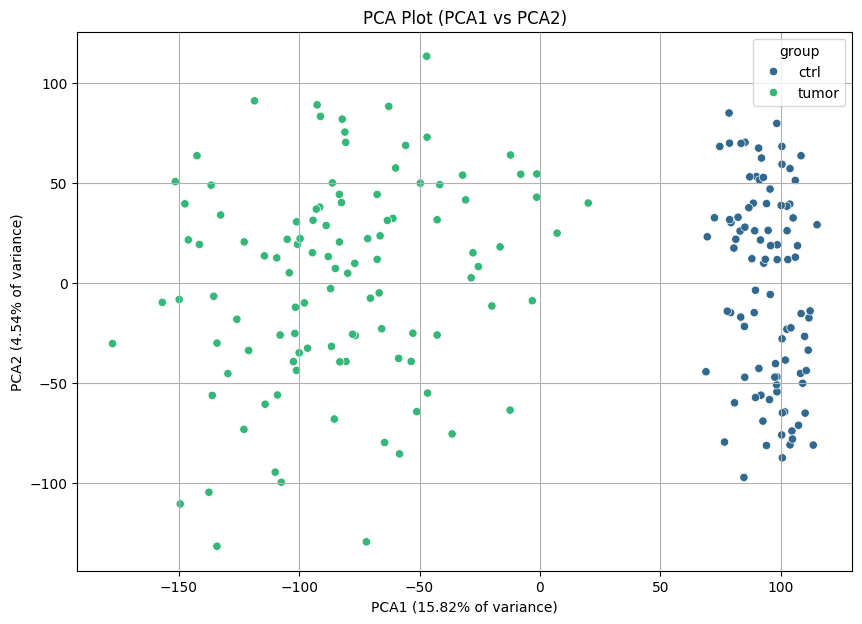

,PCA1,PCA2,group
0,106.909831,18.647095,ctrl
1,79.127035,-14.830485,ctrl
2,83.073833,26.008534,ctrl
3,80.513726,17.490658,ctrl
4,115.026522,29.164075,ctrl


In [27]:
nc.visual.plot_pca(transcriptomics, transcriptomics_meta).head()

Number of genes filled: 4746
Number of genes removed: 12677


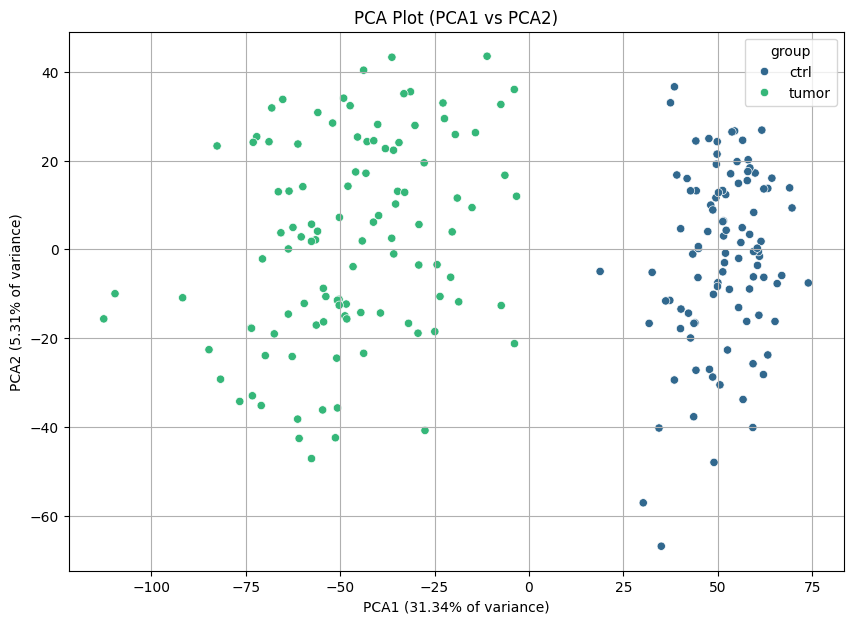

,PCA1,PCA2,group
0,43.622306,-37.733161,ctrl
1,44.305112,13.214261,ctrl
2,49.847993,24.287739,ctrl
3,59.430243,-6.199679,ctrl
4,48.995198,-48.027099,ctrl


In [28]:
nc.visual.plot_pca(phosphoproteomics, phosphoproteomics_meta).head()

Number of genes filled: 802
Number of genes removed: 1405


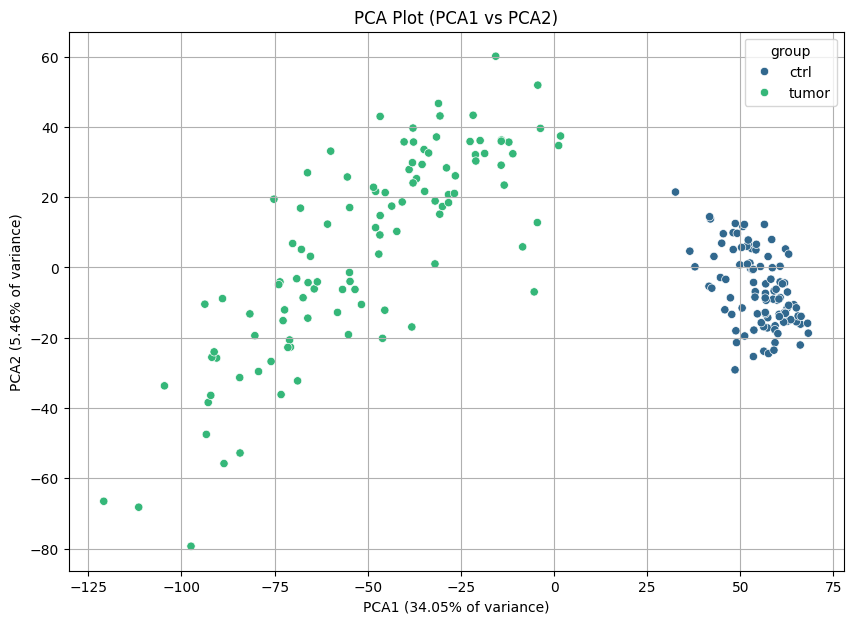

,PCA1,PCA2,group
0,56.460184,12.249532,ctrl
1,50.674229,11.655027,ctrl
2,58.424016,7.944417,ctrl
3,62.538869,-11.643738,ctrl
4,59.310804,-21.416617,ctrl


In [29]:
nc.visual.plot_pca(proteomics, proteomics_meta).head()

And there are! We can easily differentiate the healthy and tumor tissues.

Now, since the data is indexed using ENSEMBL IDs, but our prior-knowledge network is in gene symbols, we will use the `get_ensembl_mappings()` and `convert_ensembl_to_gene_symbol()` to convert them.

In [30]:
ensembl_mapping = nc.data.omics.get_ensembl_mappings()

In [31]:
transcriptomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(transcriptomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 19731 (32.52%)
Number of summarized duplicated entries: 19787 (32.61%)


In [32]:
proteomics_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(proteomics, ensembl_mapping)

Number of non-matched Ensembl IDs: 9 (0.08%)
Number of summarized duplicated entries: 9 (0.08%)


For phosphoproteomics, since we want to keep the phosphosite-level information, we need to translate the ensembl ids and then concatenate them to the phosphosite-specific fifteenmer.

In [24]:
phosphoproteomics[['gene', 'prot', 'psite', 'seq', 'n']] = phosphoproteomics['idx'].str.split('|', expand=True)
phosphoproteomics.drop('idx', inplace=True, axis=1)

In [25]:
phospho_renamed = nc.data.omics.convert_ensembl_to_gene_symbol(phosphoproteomics, ensembl_mapping, column_name='gene')

Number of non-matched Ensembl IDs: 20 (0.09%)
Number of summarized duplicated entries: 20 (0.09%)


In [26]:
phospho_renamed['gene_symbol'] = phospho_renamed['gene_symbol'] + '_' + phospho_renamed['seq']
phospho_renamed.drop(columns=['seq', 'prot', 'psite', 'n'], inplace=True)
phospho_renamed.head()

,gene_symbol,C3L-02665_ctrl,C3L-01663_ctrl,C3N-02575_ctrl,C3L-02546_ctrl,C3L-02963_ctrl,C3N-04162_ctrl,C3L-02646_ctrl,C3N-02285_ctrl,C3N-03875_ctrl,...,C3N-03425_tumor,C3L-02163_tumor,C3N-04124_tumor,C3L-00904_tumor,C3N-00211_tumor,C3N-01892_tumor,C3L-00603_tumor,C3L-03965_tumor,C3N-03851_tumor,C3L-02349_tumor
0,M6PR_DDQLGEESEERDDHL,24.778932,24.144195,24.245553,24.187865,23.991156,24.624274,23.925634,24.189010,24.203136,...,24.531595,24.449057,23.827787,24.628376,24.798447,24.181133,24.707735,24.829209,24.645253,24.593752
1,FKBP4_ATESGAQSAPLPMEG,NaN,NaN,NaN,NaN,17.920002,17.300646,15.945863,17.331397,17.390902,...,18.770883,18.833239,18.042070,18.860551,17.925153,16.956938,17.824933,17.856646,17.668338,18.772649
2,FKBP4_SNTAGSQSQVETEA_,21.609856,22.285378,21.553986,21.848364,NaN,NaN,NaN,NaN,NaN,...,23.542695,24.386651,24.018000,22.916853,22.706242,22.450601,23.535123,22.299684,22.409570,22.595958
3,CFTR_FSAERRNSILTETLH,19.123291,18.883819,18.418466,18.790913,NaN,NaN,NaN,NaN,NaN,...,19.174722,17.562886,18.433573,18.270846,18.045446,NaN,NaN,NaN,NaN,NaN
4,CFTR_EPLERRLSLVPDSEQ,NaN,NaN,NaN,NaN,19.708528,20.897510,19.990214,20.067804,20.278168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we will perform differential expression analysis. Since neither of the three files contain raw counts, which is the input for DESeq2 (the implemented DE pipeline in NetworkCommons), we have to use another method. Here, we will use a combination of variance stabilising normalization and limma, via FLOP:

> Paton et al., Assessing the impact of transcriptomics data analysis pipelines on downstream functional enrichment results. *Nucleic Acids Research, 2024*.https://doi.org/10.1093/nar/gkae552

Bear in mind that the Poetry environment does not contain any of the necessary R packages. In order to run the following chunks, you will have to create a conda environment and change the running interpreter. If you want to use FLOP, please check [the FLOP repository](https://github.com/saezlab/flop) for instructions. If you have already your DE files, then you can import them and go directly to the next section.

We need first to export the files to tsv format, both the matrices and metadata.

In [ ]:
transcriptomics_renamed.to_csv('./flop_input/rna/rna__countdata.tsv', index=False, sep='\t')
proteomics_renamed.to_csv('./flop_input/prot/prot__countdata.tsv', index=False, sep='\t')
phospho_renamed.to_csv('./flop_input/phospho/phospho__countdata.tsv', index=False, sep='\t')
transcriptomics_meta.to_csv('./flop_input/rna/rna__metadata.tsv', index=False, sep='\t')
proteomics_meta.to_csv('./flop_input/prot/prot__metadata.tsv', index=False, sep='\t')
phosphoproteomics_meta.to_csv('./flop_input/phospho/phospho__metadata.tsv', index=False, sep='\t')

In [32]:
contrast = pd.DataFrame({'group1': 'tumor', 'group2': 'ctrl'}, index=[0])
contrast.to_csv('./flop_input/rna/rna__contrast.tsv', index=False, sep='\t')
contrast.to_csv('./flop_input/prot/prot__contrast.tsv', index=False, sep='\t')
contrast.to_csv('./flop_input/phospho/phospho__contrast.tsv', index=False, sep='\t')

Now we can launch FLOP:

In [1]:
%%bash
nextflow -C $HOME/flop/flop.config run $HOME/flop/flop.nf -params-file $HOME/networkcommons/flop_run/params_flop.json -profile desktop --data_folder $HOME/networkcommons/data/flop_input --outdir .

N E X T F L O W  ~  version 22.10.6
Launching `/home/victo/flop/flop.nf` [crazy_wiles] DSL2 - revision: e70071274d
##########################################################################
 Welcome to
.------..------..------..------.
|F.--. ||L.--. ||O.--. ||P.--. |
| :(): || :/\: || :/\: || :/\: |
| ()() || (__) || :\/: || (__) |
|  -- F||  -- L||  -- O||  -- P|
'------''------''------''------'

 The FunctionaL Omics Preprocessing platform is
 a workflow meant to evaluate the impact of different
 normalization and differential expression tools on the
 resulting functional space, in the context of bulk RNA-seq data.

 ##########################################################################

[-        ] process > ge... -
[-        ] process > co... -

[-        ] process > ge... -
[-        ] process > co... -
[-        ] process > di... -
[-        ] process > ou... -

[
[
[-        ] process > di... -
[-        ] process > ou... -
[skipping] Stored process > get_prsources

executor

All done! Now we can reimport the files as dataframes:

In [2]:
de_transcr = pd.read_csv('./flop_results/diffexp/rna__deresults.tsv', sep='\t', index_col='ID')
de_transcr.columns = de_transcr.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__rna__NA', '')
de_transcr.head()

,logFC,padj,stat
ID,,,
A1BG,0.014496,6.786974e-01,0.579176
A1BG-AS1,-0.069667,2.449190e-04,-3.939982
A1CF,0.214154,5.928933e-04,3.696261
A2M,-0.258646,3.098881e-62,-25.393641
A2M-AS1,-0.246159,2.881631e-35,-15.636234


In [3]:
de_prot = pd.read_csv('./flop_results/diffexp/prot__deresults.tsv', sep='\t', index_col='ID')
de_prot.columns = de_prot.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__prot__NA', '')
de_prot.head()

,logFC,padj,stat
ID,,,
A1BG,-0.052922,2.056921e-66,-26.394359
A2M,-0.070913,4.092248e-57,-22.872089
A2ML1,0.069956,1.335629e-11,7.279300
A4GALT,0.027591,5.895337e-08,5.810764
AAAS,0.020772,3.045301e-34,15.030391


In [4]:
de_phospho = pd.read_csv('./flop_results/diffexp/phospho__deresults.tsv', sep='\t', index_col='ID')
de_phospho.columns = de_phospho.columns.str.replace('__unfiltered__log2quant+limma__tumor_v_ctrl__phospho__NA', '')
de_phospho.head()

,logFC,padj,stat
ID,,,
AAAS_NAQFPRFSPVLGRAQ,0.060223,2.823895e-48,20.033231
AAGAB_DEIEGLSSDEEH___,0.108586,1.071774e-31,14.976394
AAK1_AGHRRILSDVTHSAV,0.020751,3.033704e-03,3.096315
AAK1_ATTTPSGSPRTSQQN,0.026691,1.527565e-12,7.689493
AAK1_FGVPASKSTQLLQAA,0.099484,6.248940e-36,15.787061


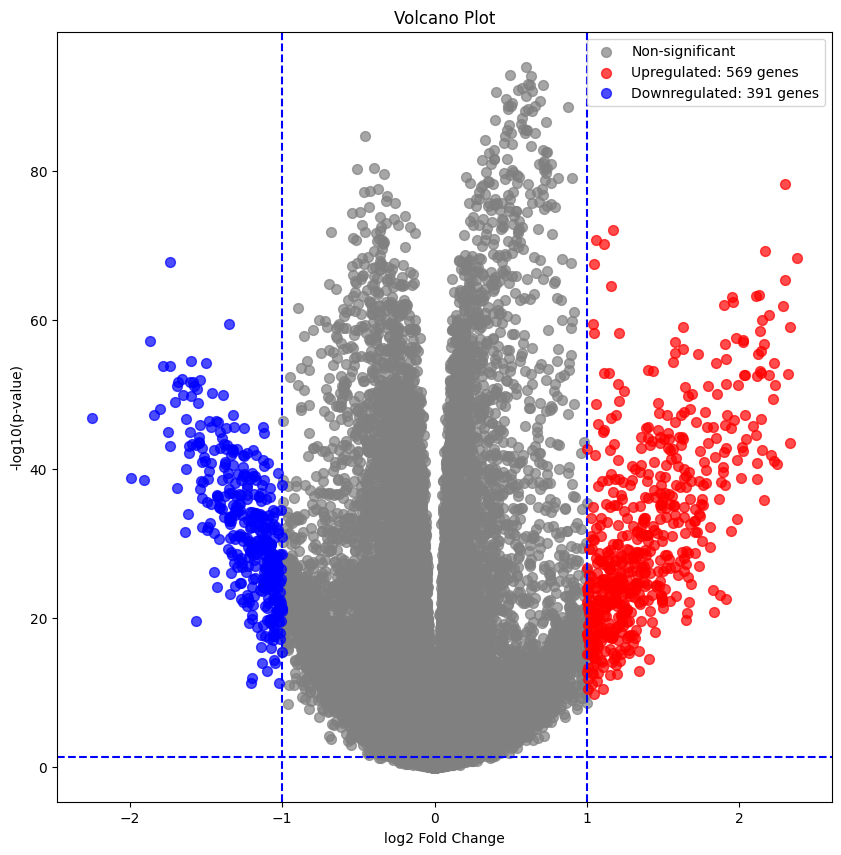

In [5]:
nc.visual.build_volcano_plot(data=de_transcr, log2fc='logFC', pval='padj')

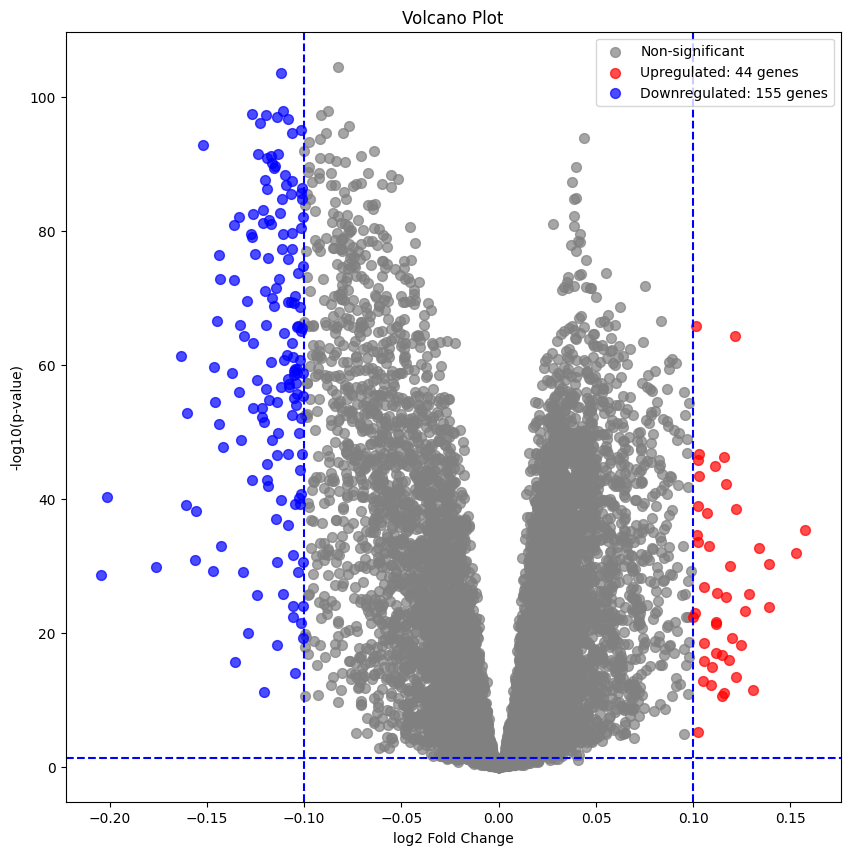

In [6]:
nc.visual.build_volcano_plot(data=de_prot, log2fc='logFC', pval='padj', log2fc_threshold=0.1)

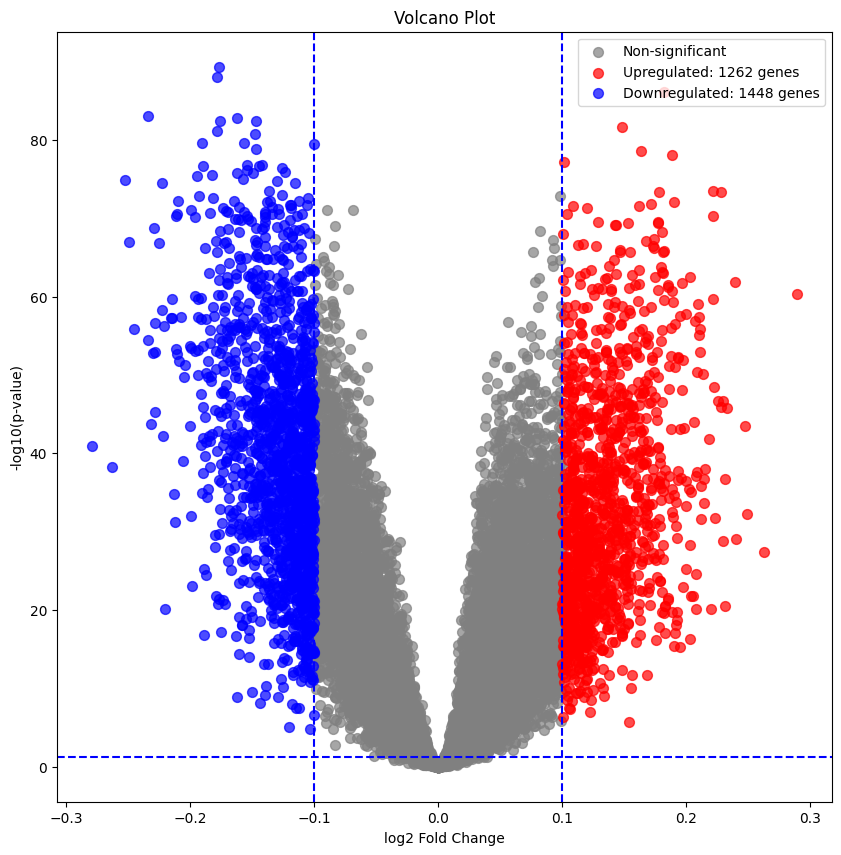

In [7]:
nc.visual.build_volcano_plot(data=de_phospho, log2fc='logFC', pval='padj', log2fc_threshold=0.1)

## 2. Prior knowledge and inputs

Now that we have our data preprocessed, we can proceed to defining the inputs of the network inference methods. For the upstream layer, we will identify the most abundant receptors (using information from LIANA) in the proteome. For the downstream layer, we will perform TF activity estimation using the transcriptomics data.

In [8]:
liana_receptors = nc.data.network.get_lianaplus()

In [9]:
receptors = set(liana_receptors.target)

In [33]:
receptors_prot = de_prot[de_prot.index.isin(receptors)]

top_receptors = receptors_prot.sort_values(by='stat', key=lambda x: x.abs(), ascending=False).head(5)

In [34]:
top_receptors

,logFC,padj,stat
ID,,,
PTPRM,-0.087538,1.330248e-98,-41.550192
ESAM,-0.097282,5.554886e-94,-38.877270
CDH5,-0.097742,2.639623e-90,-36.967655
TGFBR2,-0.086405,2.071393e-89,-36.520523
CAV1,-0.106198,3.653773e-88,-35.896881


In [35]:
source_dict = top_receptors['stat'].to_dict()

We can see the overall abundance of these receptors in the original data.

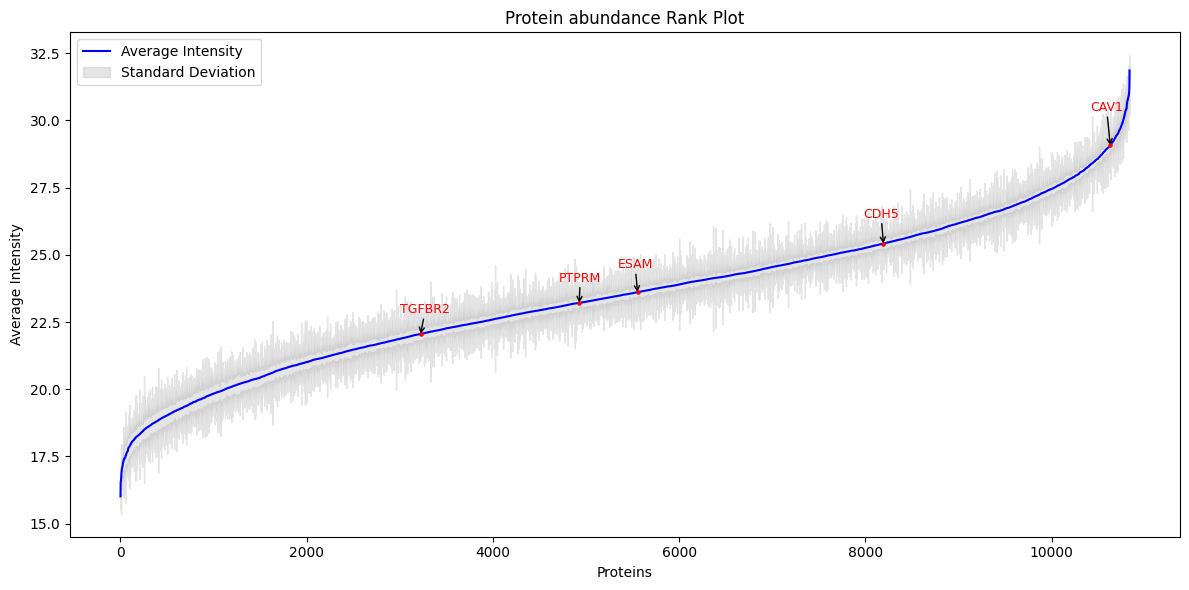

In [36]:
nc.visual.plot_rank(proteomics_renamed, bio_ids=source_dict.keys(), id_column='gene_symbol')

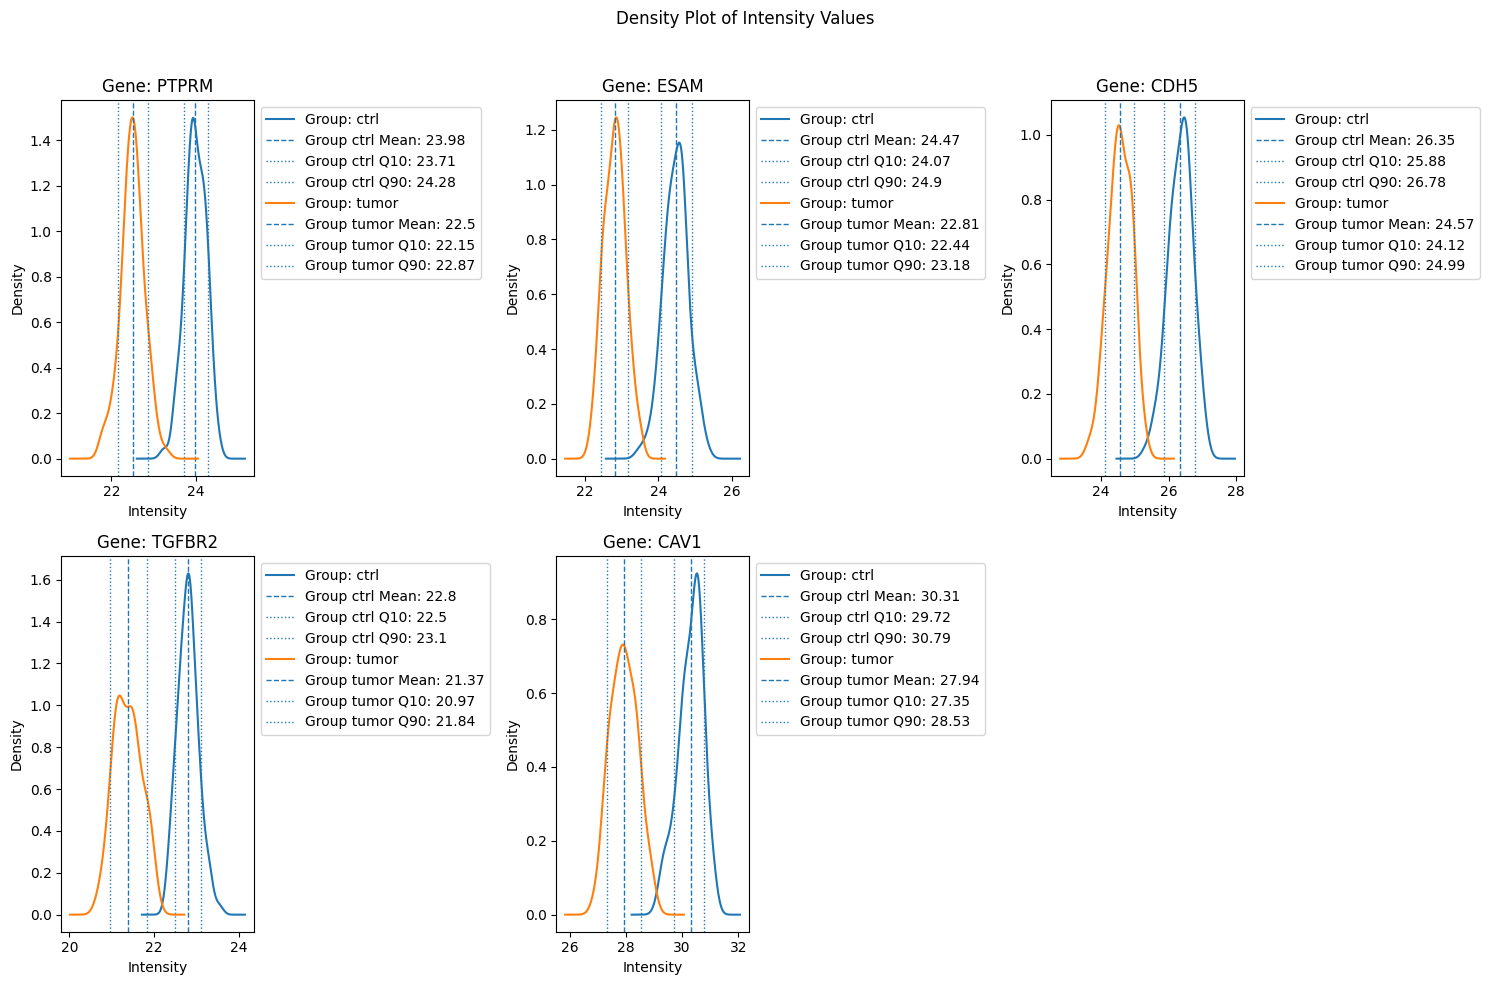

In [37]:
nc.visual.plot_density(df=proteomics_renamed, gene_ids=source_dict.keys(), id_column='gene_symbol', metadata=proteomics_meta)

All these receptors are downregulated in the tumor samples. Therefore, we assume them to be especially important to explain the mechanisms of disease we aim to capture.

Now, we can perform TF activity estimation and use them as downstream measurements

In [38]:
collectri = dc.get_collectri()

In [39]:
tfs = collectri.source.values

In [40]:
decoupler_input = nc.utils.decoupler_formatter(de_transcr, 'stat')
dc_estimates, dc_pvals = dc.run_ulm(decoupler_input, collectri)
measurements = nc.utils.targetlayer_formatter(dc_estimates.T)

Now, we will perform Kinase activity estimation using PhosphoSitePlus. We will then use this information to evaluate the network on the basis of wether its nodes are overall more dysregulated than the overall phosphoproteome landscape.

In [41]:
phosphositeplus = nc.data.network.get_phosphositeplus()
phosphositeplus = phosphositeplus[phosphositeplus['KIN_ORGANISM'] == 'human']
phosphositeplus['target'] = phosphositeplus['SUB_GENE'] + '_' + phosphositeplus['SITE_+/-7_AA'].str.upper()
phosphositeplus.rename(columns={'KINASE': 'source'}, inplace=True)
phosphositeplus.drop_duplicates(subset=['source', 'target'], inplace=True)
phosphositeplus = phosphositeplus[['source', 'target']]
phosphositeplus.head()

,source,target
5,HRI,Eif2s1_MILLSELSRRRIRSI
6,HRI,EIF2S1_RILLSELSR______
7,HRI,EIF2S1_MILLSELSRRRIRSI
8,HRI,EIF2S1_IEGMILLSELSRRRI
9,PKCD,Sdc4_MKKKDEGSYDLGKKP


In [42]:
kinases = set(phosphositeplus.source)
len(kinases)

445

In [43]:
decoupler_input_kin = nc.utils.decoupler_formatter(de_phospho, 'stat')
dc_estimates_kin, dc_pvals_kin = dc.run_zscore(decoupler_input_kin, phosphositeplus, weight=None)
kinase_activities = dc_estimates_kin.T
kinase_activities.head()
len(kinase_activities)

88

We could infer activities for 88 out of the 445 available kinases.

In [44]:
kinase_activities.head()

,stat
AMPKA1,2.493103
AMPKA2,0.023193
ATM,3.289643
ATR,1.802904
Abl,-3.407031


Lastly, now that we have our data ready, we can get the network from OmniPath.

In [45]:
network = nc.data.network.get_omnipath()
network = network[~network['source'].isin(tfs)] # we remove communication to the GRN layer
network.head()


,source,target,sign
0,CALM1,TRPC1,-1
1,CALM3,TRPC1,-1
2,CALM2,TRPC1,-1
3,CAV1,TRPC1,1
4,MDFI,TRPC1,-1


In [46]:
graph = nc.utils.network_from_df(network)

## 3. Network inference

Now, we can perform network inference using basic topological methods. We will store the network in a dictionary to ease further downstream analysis.

In [47]:
networks = {}

In [48]:
networks['shortest_path'], shortest_paths_list = nc.methods.run_shortest_paths(graph, source_dict, measurements)

In [49]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_path'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

The network is too large to visualize.


None

In [50]:
networks['shortest_sc_path'], shortest_sc_list = nc.methods.run_sign_consistency(networks['shortest_path'], shortest_paths_list, source_dict, measurements)

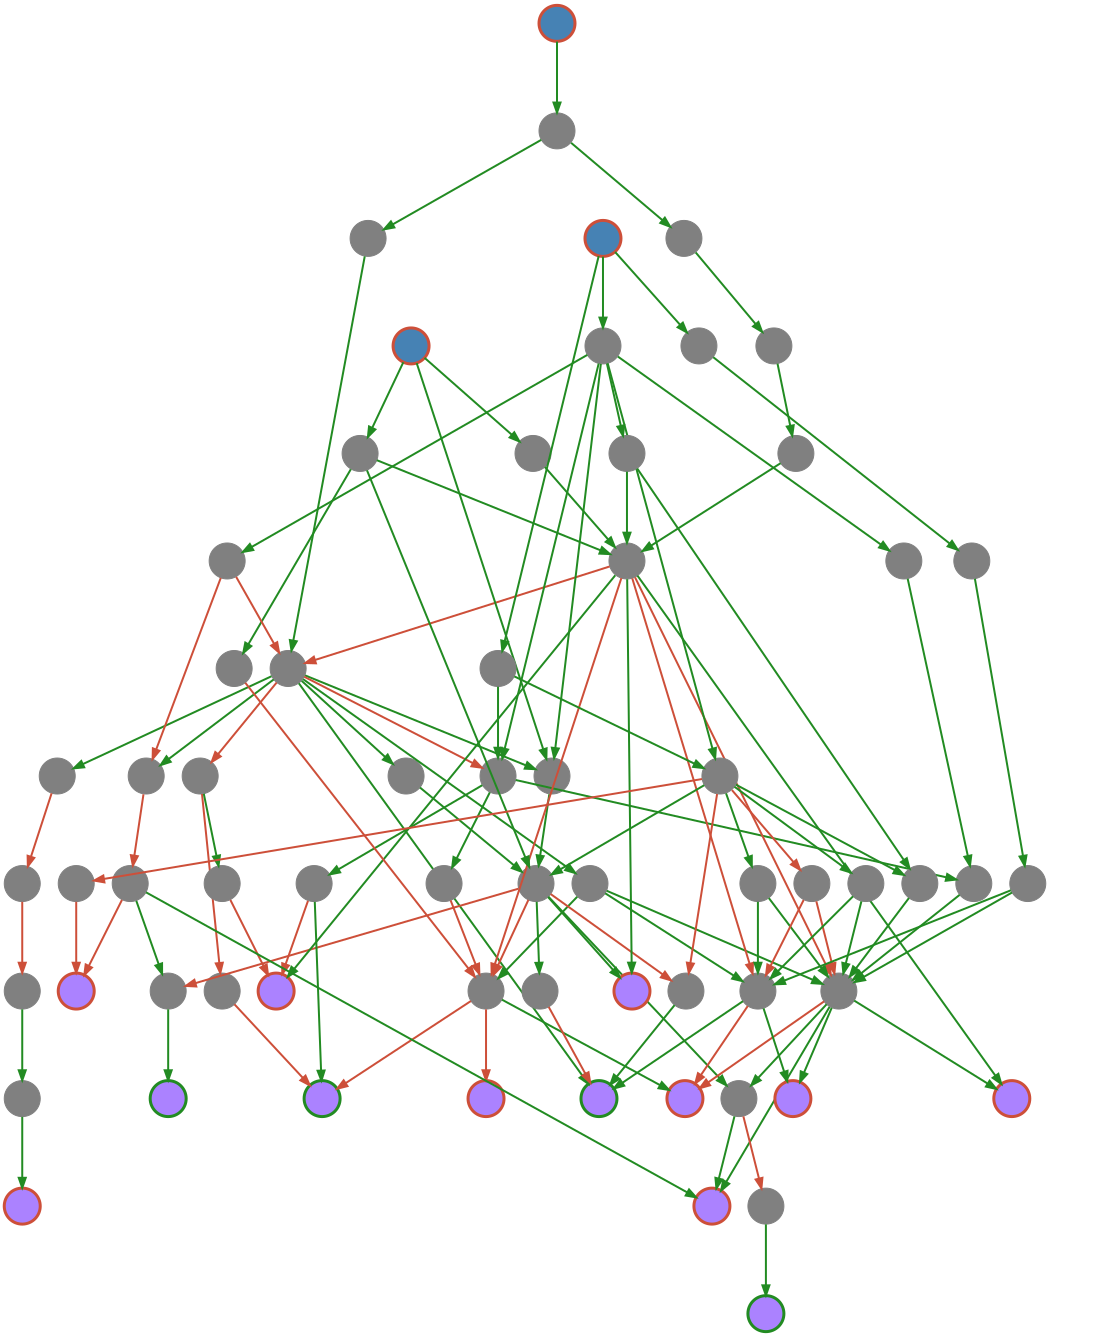

In [51]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['shortest_sc_path'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

In [52]:
networks['all_paths'], all_paths_list = nc.methods.run_all_paths(graph, source_dict, measurements, depth_cutoff=6)

In [53]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_paths'], source_dict, measurements, is_sign_consistent=False)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

The network is too large to visualize.


None

In [54]:
networks['all_sc_paths'], allpaths_sc_list = nc.methods.run_sign_consistency(networks['all_paths'], all_paths_list, source_dict, measurements)

In [55]:
from IPython.display import HTML, display
a = nc.visual.visualize_graph_simple(networks['all_sc_paths'], source_dict, measurements, is_sign_consistent=True)
style = "<style>svg{width:25% !important;height:25% !important;</style>"
display(HTML(style))
display(a)

The network is too large to visualize.


None

In [59]:
networks['corneto_graph'] = nc.methods.run_corneto_carnival(graph, source_dict, measurements, betaWeight=0.01, solver='GUROBI')

(CORNETO) Aug 15 04:43:41 PM - INFO    : 4/5 inputs mapped to the graph
(CORNETO) Aug 15 04:43:41 PM - INFO    : 14/25 outputs mapped to the graph
(CORNETO) Aug 15 04:43:41 PM - INFO    : Pruning the graph with size: V x E = (4537, 11223)...
(CORNETO) Aug 15 04:43:41 PM - INFO    : Finished. Final size: V x E = (739, 3271).
(CORNETO) Aug 15 04:43:41 PM - INFO    : 3/4 inputs after pruning.
(CORNETO) Aug 15 04:43:41 PM - INFO    : 13/14 outputs after pruning.
(CORNETO) Aug 15 04:43:41 PM - INFO    : Converting into a flow graph...
(CORNETO) Aug 15 04:43:42 PM - INFO    : Creating a network flow problem...
(CORNETO) Aug 15 04:43:42 PM - INFO    : Preprocess completed.
                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 15 04:43:42 PM: Your problem has 15491 variables, 37640 constraints, and 0 parameters.
(CVXPY) Aug 15 04:43:42 PM: It is compliant with the following gra

## 4. Network evaluation using level of dysregulation in the phosphoproteome.

Now, at last, we are in the position to test our hypotheses. In this section, we will use the kinase activities to evaluate whether the inferred networks capture a more extreme dysregulation status (understood as average kinase activity score for the nodes in the network, versus the overall kinase activity) than the random controls (node and measurement label shuffling, but keeping the topology of the network intact).

In [60]:
sp_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_shortest_paths, 100, 'shortest_path', source_dict=source_dict, target_dict=measurements, randomise_measurements=True, item_list=list(tfs))

In [63]:
ap_random_controls = nc.eval.perform_random_controls(graph, nc.methods.run_all_paths, 100, 'all_paths', source_dict=source_dict, target_dict=measurements, depth_cutoff=6, randomise_measurements=True, item_list=list(tfs))

In [64]:
combined_dict = {}
combined_dict.update(networks)
combined_dict.update(sp_random_controls)
combined_dict.update(ap_random_controls)

In [ ]:
phospho_results = nc.eval.get_metric_from_networks(combined_dict, nc.eval.get_phosphorylation_status, dataframe=kinase_activities)

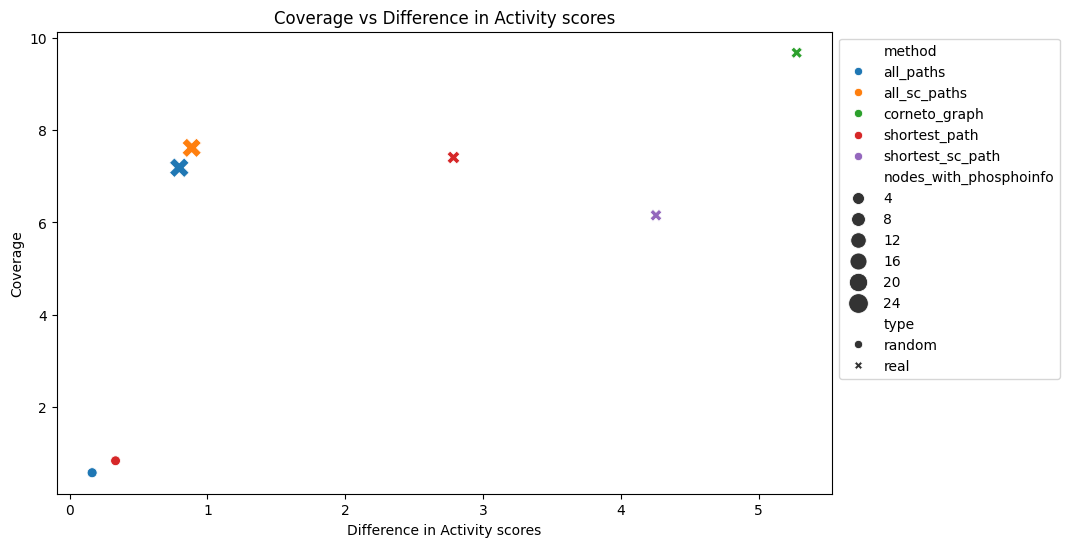

In [73]:
nc.visual.plot_scatter(phospho_results, x_col='diff_dysregulation')

The results show that our contextualised networks manage to recover a higher share of dysregulation, which means that in this scenario, the network methods perform much better than a random model, especially the CORNETO graph. CORNETO also gets the highest coverage, almost 10% of the nodes are active kinases.

<div class="alert alert-block alert-info">
<b>⚠️</b> This approach has the flaw of having usually low coverage of kinase activities, thus the inferred dysregulation might not come from a representative set of kinases. This evaluation setting is still under development.
</div>